In [2]:
import cv2
import numpy as np
import os
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt 

In [2]:
def img_load(folder,count=None,size=None):
    images = []
    i = 0
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            i += 1
            if i%50 == 0:
                clear_output()
                print (i)
            if count is not None:
                if count == 0:
                       break
                else:
                    count -= 1
            
            if size is not None:
                img = cv2.resize(img,size,interpolation = cv2.INTER_CUBIC)
            images.append((filename,img))

    return images

In [4]:
melanoma = img_load('./data/melanoma',None,(256,128))

350


In [5]:
others = img_load('./data/others',None,(256,128))

1600


In [3]:
def classify_mel_data(data,gt_path):
    classification_dataset = []
    
    for filename in os.listdir(gt_path):
        for data_list in data:
            entry = [row[1] for row in data_list if row[0][:-4] in filename[:-4]]
            if entry:
                gt_img = cv2.imread(os.path.join(gt_path,filename),0)
                gt_img = cv2.resize(gt_img,(entry[0].shape[1],entry[0].shape[0]),interpolation = cv2.INTER_CUBIC)
                #gt_img = gt_img.reshape((gt_img.shape[0],gt_img.shape[1],1))
                
                mask = gt_img < 150
                train_img = entry[0]
                train_img[mask] = 0
                
                label = int(len(data_list) < 500)
                classification_dataset.append((train_img,label))
                
                    

    return classification_dataset
        
        

In [7]:
dataset = classify_mel_data([melanoma,others],'./data/gt/')

In [8]:

train_size = int(len(dataset)*0.8)

x_train = np.array([row[0]/255. for row in dataset[0:train_size]])
y_train = np.array([row[1] for row in dataset[0:train_size]])

x_test = np.array([row[0]/255. for row in dataset[train_size:]])
y_test = np.array([row[1] for row in dataset[train_size:]])

In [19]:

x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')


In [4]:
x_train.shape

(1600, 128, 256, 3)

In [3]:
from keras.layers import *
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.utils import plot_model
from sklearn.utils import class_weight
from keras.applications import vgg16

import tensorflow as tf
import keras.backend as K

c:\users\admin\anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [28]:
def basic_netw(input_shape = (None,None,3),num_classes = 1):
    inputs = Input(shape=input_shape)
    
    conv1 = Conv2D(32, (3, 3), padding='same', activation = 'relu')(inputs)
    pool1 = MaxPooling2D(pool_size = (3, 3))(conv1)
    
    conv2 = Conv2D(64, (2, 2), padding='same', activation = 'relu')(pool1)
    pool2 = MaxPooling2D(pool_size = (3, 3))(conv2)
    
    
    flat_vector = Flatten()(pool2)
    
    dense1 = Dense(units = 256, activation = 'relu')(flat_vector)
    dropout1 = Dropout(0.5)(dense1)
    
    out = Dense(units = 1, activation = 'sigmoid')(dropout1)
    
    model = Model(inputs=inputs, outputs=out)
    
    return model

In [29]:
model = basic_netw(input_shape=(128,256,3))
model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics = ['accuracy'])



trainable_count 6432193 non_trainable_count 0 gbytes 0.238 mbytes 243.301


In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 256, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 85, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
__________

In [ ]:
model_checkpoint = ModelCheckpoint('./basic_conv.hdf5',save_best_only=True)


Instructions for updating:
Use the retry module or similar alternatives.


In [ ]:
history = model.fit(x_train,y_train,epochs=10,batch_size=32,class_weight=(0.5,2.4),validation_data = (x_test,y_test),callbacks=[model_checkpoint])

In [101]:
x_train.shape

(1600, 128, 256, 3)

In [25]:
model = load_model('./basic_conv.hdf5')
y_pred = model.predict(x_test,verbose=1)

400/400 [==============================] - 2s 5ms/step


In [26]:
y_pred_class = y_pred > 0.5

In [27]:
print ("Precision Score %f",precision_score(y_test,y_pred_class))

Precision Score %f 0.0


In [12]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


class_names = ["Melanoma","Others"]
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
np.set_printoptions(precision=2)



Confusion matrix, without normalization
[[292   1]
 [60   47]]
Normalized confusion matrix
[[ 0.99658703  0.00341297]
 [ 0.56074766  0.43925234]]


Confusion matrix, without normalization
[[292   1]
 [ 60  47]]
Normalized confusion matrix
[[ 0.99658703  0.00341297]
 [ 0.56074766  0.43925234]]


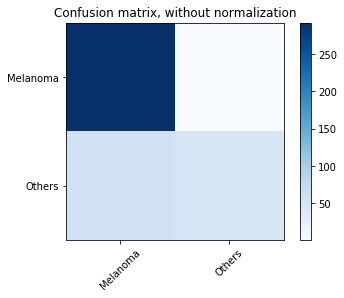

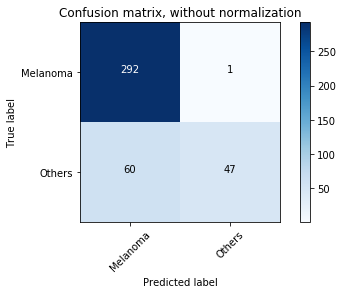

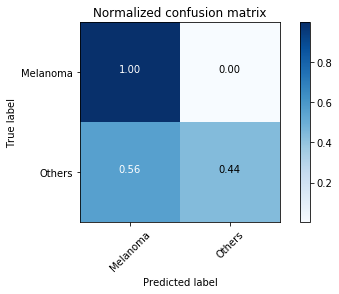

In [10]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [30]:
confusion_matrix(y_test,y_pred_class)

array([[250,  43],
       [ 86,  21]], dtype=int64)